In [ ]:
!git clone https://github.com/ch2343/scCRAFT.git

Cloning into 'scCRAFT'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 142 (delta 74), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (142/142), 4.71 MiB | 8.54 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [ ]:
%cd scCRAFT
!pip install .

/content/scCRAFT
Processing /content/scCRAFT
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 2.8 MB/s eta 0:00:00
  Created wheel for scCRAFT: filename=scCRAFT-1.0.0-py3-none-any.whl size=13804 sha256=f34a284e9e06c855c990235036c53bfaed083c4d906921c2ae70550482241534
  Stored in directory: /tmp/pip-ephem-wheel-cache-s_1ohw9n/wheels/d1/07/11/48b01cf25f1f92c0fddb2850de823ecd79247d249b3a0e41ad
Successfully built scCRAFT


In [ ]:
!pip install harmonypy

In [1]:
import scanpy as sc
import numpy as np
import scCRAFT
from scCRAFT.model import *
import harmonypy as hm
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import scanorama
import scanpy as sc
import scvi
import seaborn as sns
import torch

/Users/sheena/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Suppress specific ImportWarning
warnings.filterwarnings("ignore")

/Users/sheena/Library/Python/3.9/lib/python/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/Users/sheena/Library/Python/3.9/lib/python/site-packages/matplotlib_inline/config.py:54: DeprecationWarning: InlineBackend._print_figure_kwargs_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _update_figure_formatters(self):


## read the data

In [3]:
import anndata
adata = anndata.read_h5ad("../human_pancreas_norm.h5ad")
adata

AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors'
    layers: 'counts'

In [4]:
# preprocessing
import scanpy as sc

adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='tech')
adata = adata[:, adata.var['highly_variable']]

In [5]:
embeddings_dict = {}

# Scanorama

In [6]:
import anndata as ad

def split_batches(adata, batch_key, return_categories=False):
    """
    Split an AnnData object into a list of AnnData objects by batch.
    
    Parameters:
    - adata (AnnData): The AnnData object to split.
    - batch_key (str): The key in `adata.obs` used to identify batches.
    - return_categories (bool): Whether to return the unique categories (batch labels).

    Returns:
    - list: A list of AnnData objects, one for each batch.
    - list (optional): A list of unique batch categories, if `return_categories` is True.
    """
    if batch_key not in adata.obs:
        raise ValueError(f"Batch key '{batch_key}' not found in adata.obs.")
    
    categories = adata.obs[batch_key].unique().tolist()
    split_data = [adata[adata.obs[batch_key] == batch].copy() for batch in categories]
    
    if return_categories:
        return split_data, categories
    return split_data

In [7]:
#Scanorama
# Save original order of cells
original_order = adata.obs_names.copy()

# Your existing Scanorama correction process
split, categories = split_batches(adata.copy(), 'tech', return_categories=True)
corrected = scanorama.correct_scanpy(split, return_dimred=True)
corrected = anndata.AnnData.concatenate(
    *corrected, batch_key='tech', batch_categories=categories, index_unique=None
)

# Reorder corrected data to match original order
corrected = corrected[original_order]

# Replace adata with corrected data
adatas = corrected.copy()

Found 2000 genes among all datasets
[[0.00000000e+00 6.75711160e-01 6.26959248e-02 2.38047809e-01
  1.86370676e-01 1.42430279e-01 1.79282869e-02 5.87649402e-02
  5.37848606e-02]
 [0.00000000e+00 0.00000000e+00 6.11285266e-02 6.34135667e-01
  5.73051110e-02 1.74013921e-02 3.06345733e-03 6.90713738e-03
  2.68096515e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.93416928e-02
  1.72413793e-02 0.00000000e+00 1.25391850e-02 0.00000000e+00
  4.48275862e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.06866288e-01 1.24709977e-01 1.77531207e-02 7.67459708e-02
  5.44235925e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 5.42075374e-01 6.51522974e-01 3.30775134e-01
  5.16262261e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.21345708e-01 7.21577726e-01
  6.70241287e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 4.6

In [13]:
adata.obsm['X_scanorama'] = adatas.obsm['X_scanorama']

embeddings_dict['X_scanorama'] = adata.obsm["X_scanorama"]

In [14]:
embeddings_dict.keys()

dict_keys(['X_scVI', 'X_harmony', 'X_scCRAFT', 'X_seurat', 'X_scanorama'])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


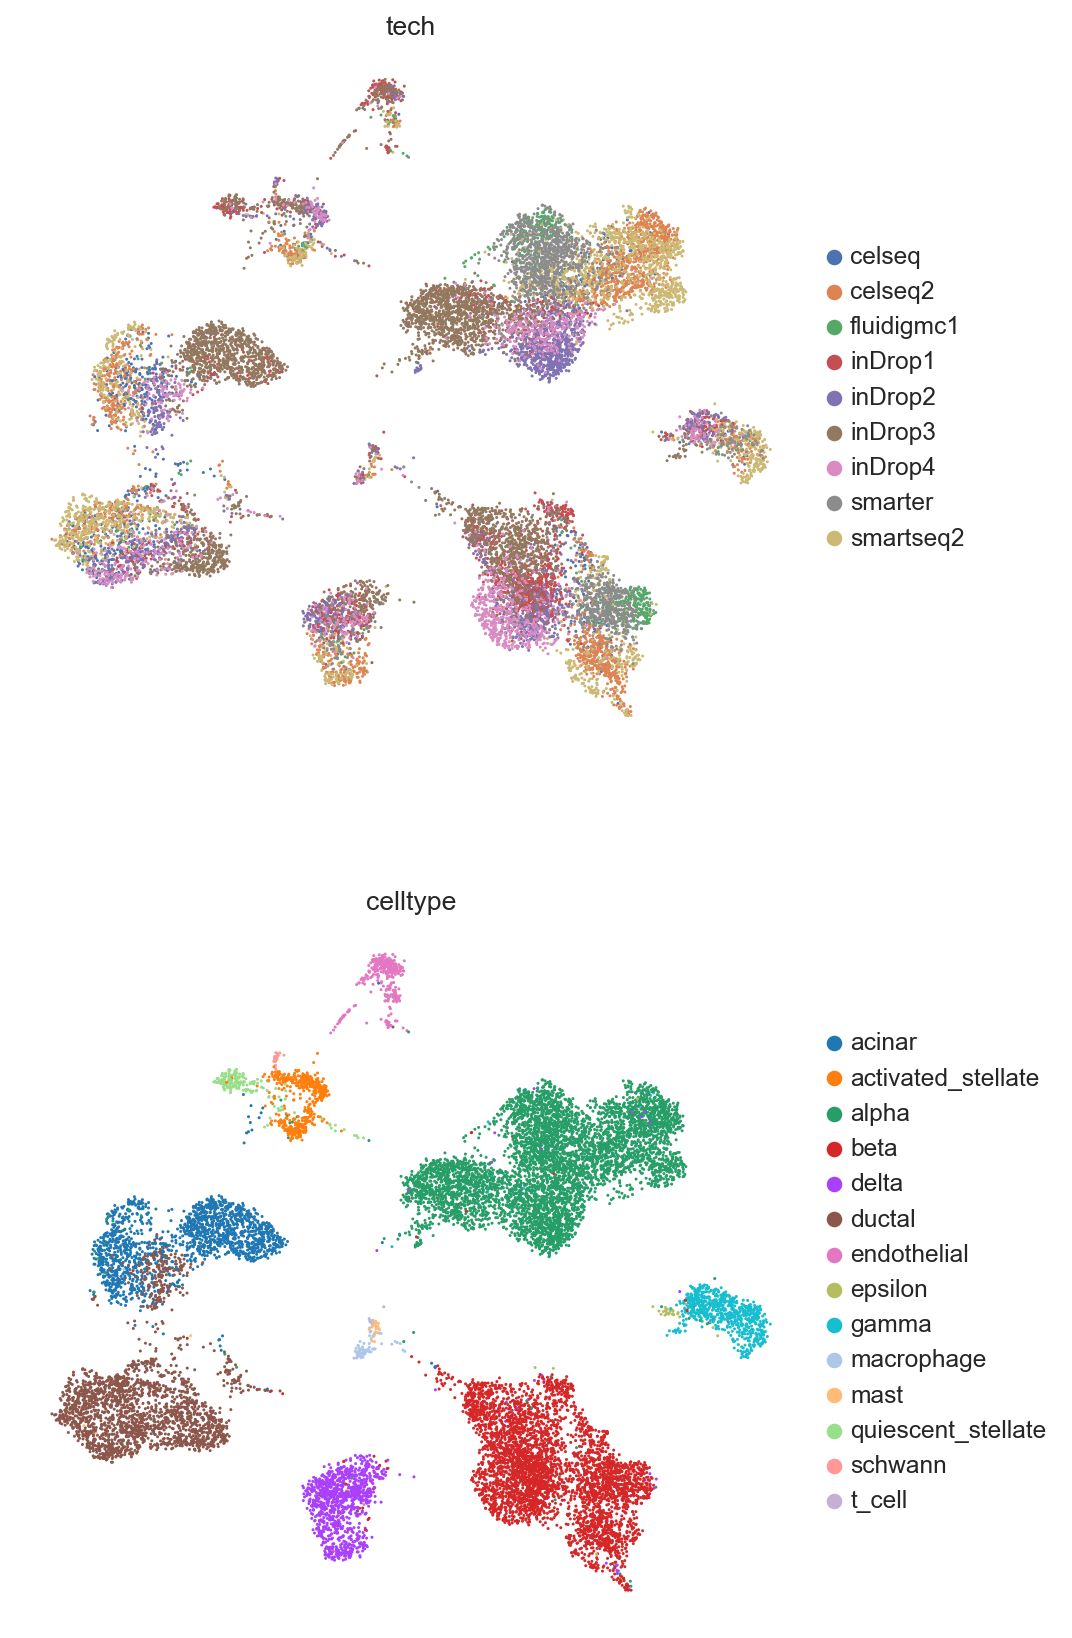

In [15]:
# Umap Plotting
sc.pp.neighbors(adata, n_pcs=30, use_rep="X_scanorama")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["tech", "celltype"], frameon=False, ncols=1)

# scVI

In [ ]:
# scVI
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="tech")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

/usr/local/lib/python3.10/dist-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers wh

Epoch 400/400: 100%|██████████| 400/400 [06:58<00:00,  1.05s/it, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.22e+3]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [06:58<00:00,  1.05s/it, v_num=1, train_loss_step=1.19e+3, train_loss_epoch=1.22e+3]


In [ ]:
# Collect embeddings
adata.obsm["X_scVI"] = adata.obsm["X_scVI"]

# Collect embeddings
embeddings_dict["X_scVI"] = adata.obsm["X_scVI"]

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


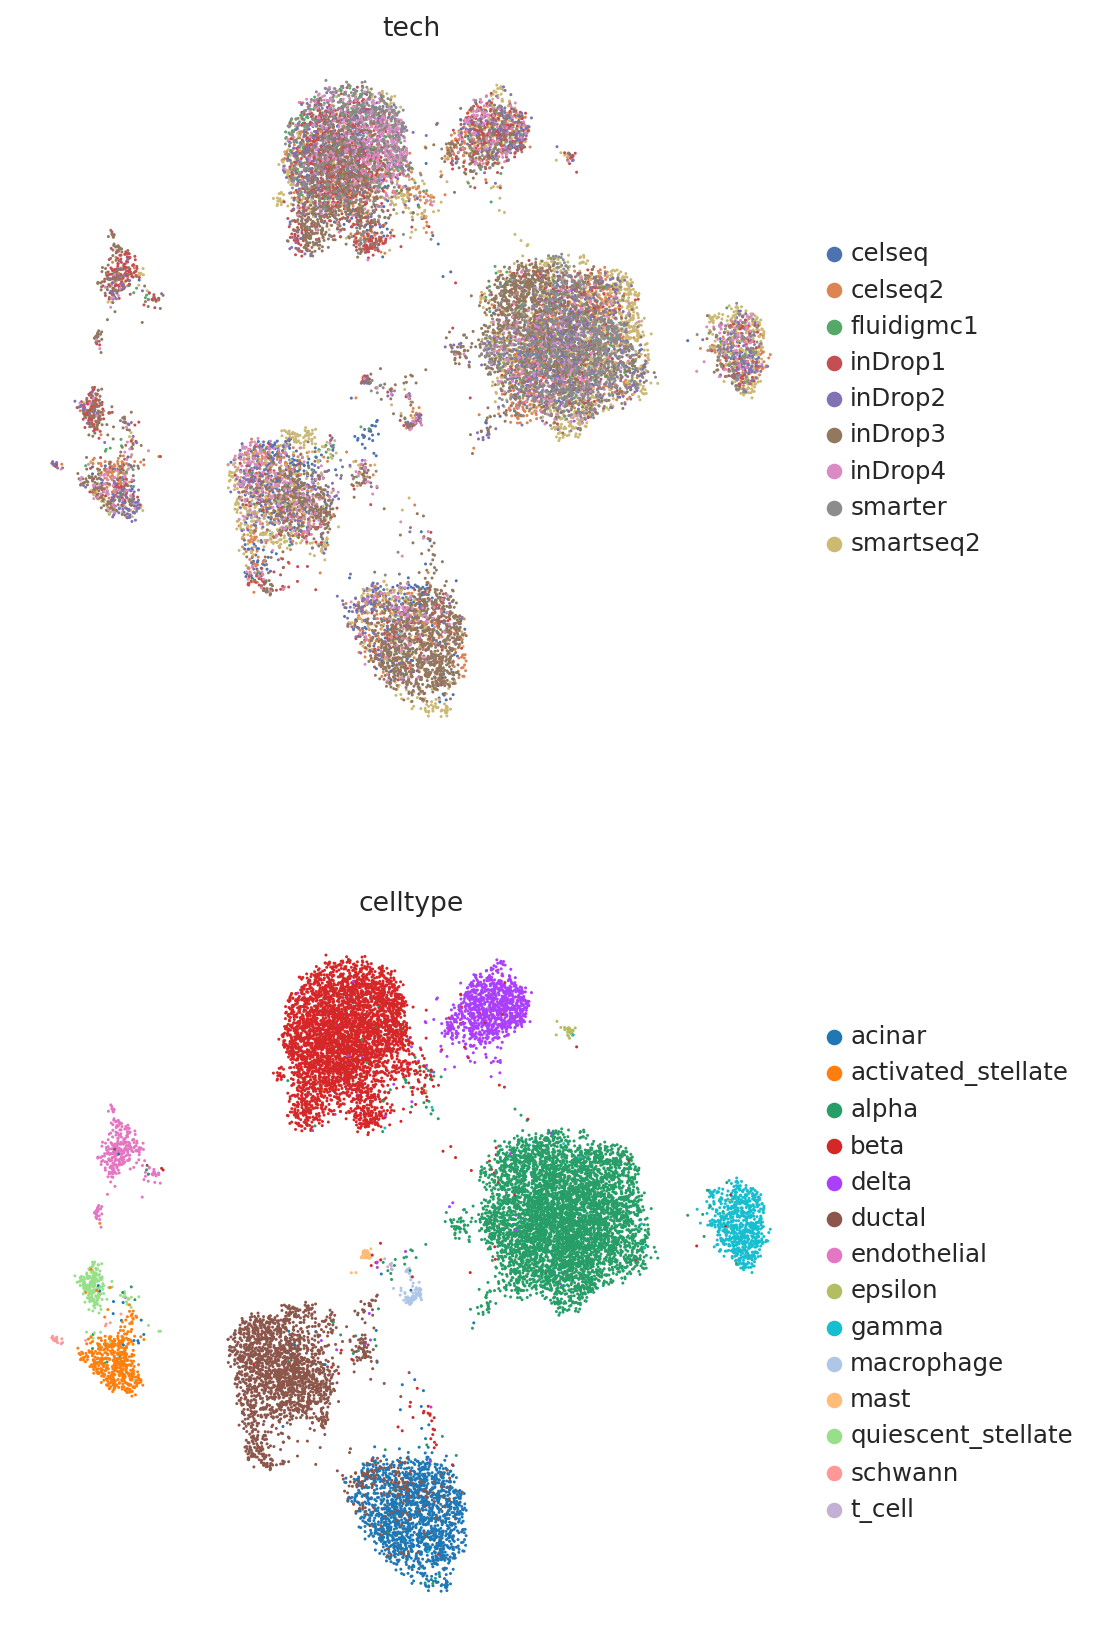

In [ ]:
sc.pl.umap(adata, color=["tech", "celltype"], frameon=False, ncols=1)

# scCRAFT

In [ ]:
# scCRAFT
multi_resolution_cluster(adata, resolution1 = 0.5, method = 'Leiden')
VAE = train_integration_model(adata, batch_key = 'tech', z_dim=256, d_coef = 0.2)
obtain_embeddings(adata, VAE)
sc.pp.neighbors(adata, use_rep="X_scCRAFT")
sc.tl.umap(adata, min_dist=0.5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/content/scCRAFT/scCRAFT/utils.py:172: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  clustering_function(adata, resolution=resolution1)


150


Overall Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training completed in 298.61 seconds


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


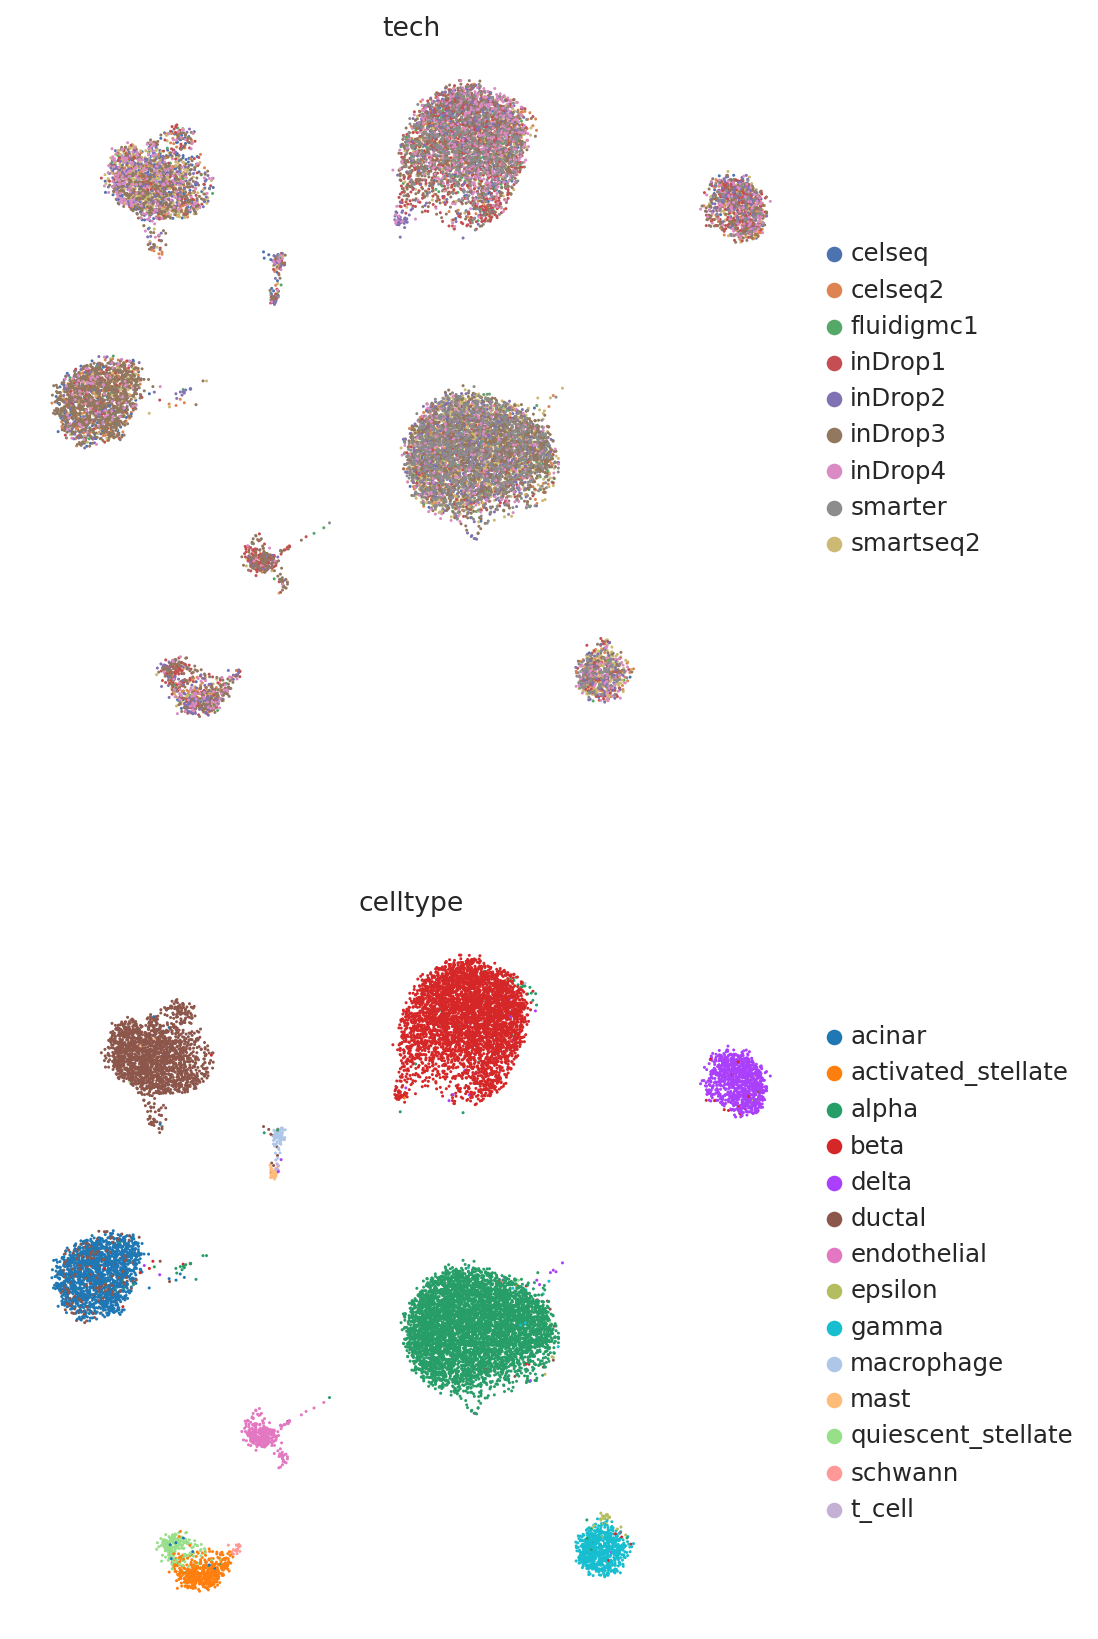

In [ ]:
sc.pl.umap(adata, color=["tech", "celltype"], frameon=False, ncols=1)

In [ ]:
# Save embeddings
adata.obsm["X_scCRAFT"] = adata.obsm["X_scCRAFT"]

# Collect embeddings
embeddings_dict["X_scCRAFT"] = adata.obsm["X_scCRAFT"]

# Harmony

In [ ]:
# Harmony
sc.tl.pca(adata, n_comps=50)
data_mat = adata.obsm['X_pca']
meta_data = adata.obs

# Specify the variables to use (as in your original code)
vars_use = ['tech']

# Run Harmony
start_time = time.time()
ho = hm.run_harmony(data_mat, meta_data, vars_use)
end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Convert the adjusted PCs to a DataFrame
res = pd.DataFrame(ho.Z_corr)
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]

# If you want to store the adjusted PCs back into the AnnData object
adata.obsm['X_harmony'] = res.values.T
sc.pp.neighbors(adata, use_rep="X_harmony")
sc.tl.umap(adata, min_dist=0.5)

2024-07-09 12:42:32,688 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2024-07-09 12:42:40,354 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2024-07-09 12:42:40,401 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2024-07-09 12:42:45,390 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2024-07-09 12:42:50,739 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2024-07-09 12:42:56,010 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2024-07-09 12:43:00,984 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2024-07-09 12:43:04,054 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2024-07-09 12:43:09,634 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2024-07-09 12:43:12,571 - 

Training completed in 39.90 seconds


In [ ]:
# Save embeddings
adata.obsm["X_harmony"] = adata.obsm["X_harmony"]

# Collect embeddings
embeddings_dict["X_harmony"] = adata.obsm["X_harmony"]

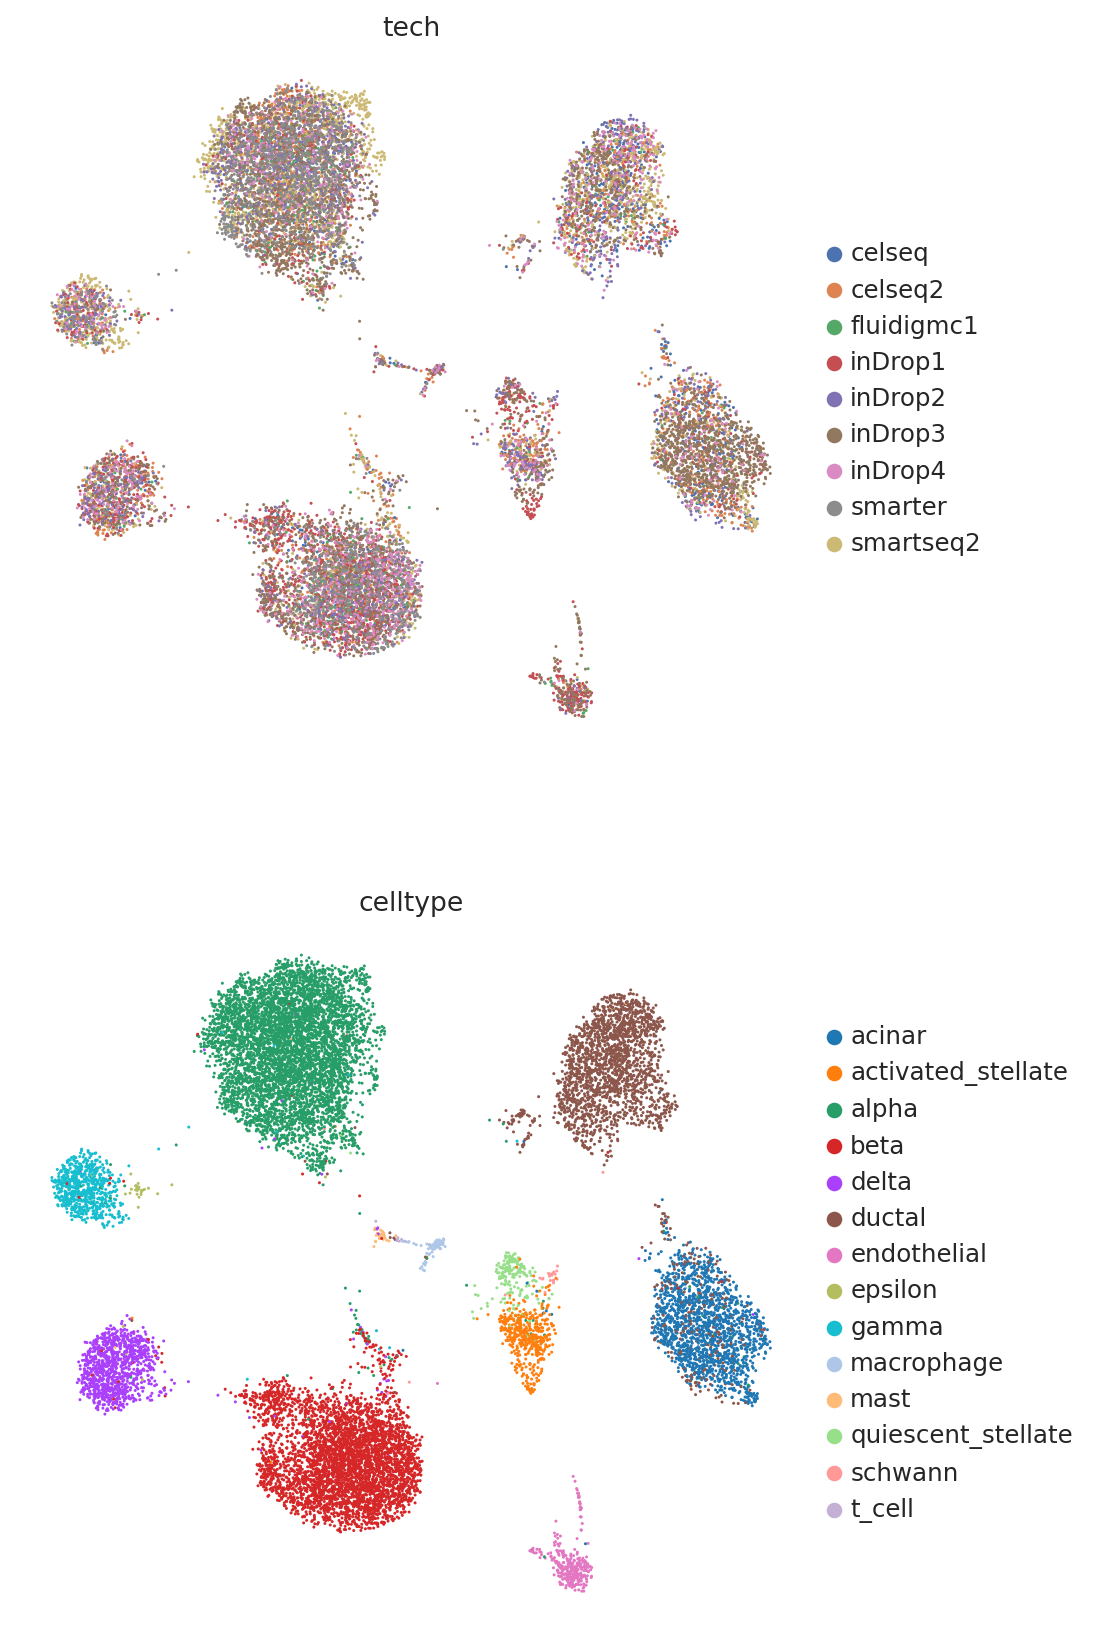

In [ ]:
sc.pl.umap(adata, color=["tech", "celltype"], frameon=False, ncols=1)

# Seurat

In [ ]:
pca_embeddings = pd.read_csv('/content/drive/MyDrive/scdata/human_pancreas_norm/human_pancreas_seurat.csv', index_col=0)
adata.obsm['X_seurat'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_seurat")
sc.tl.umap(adata, min_dist=0.5)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


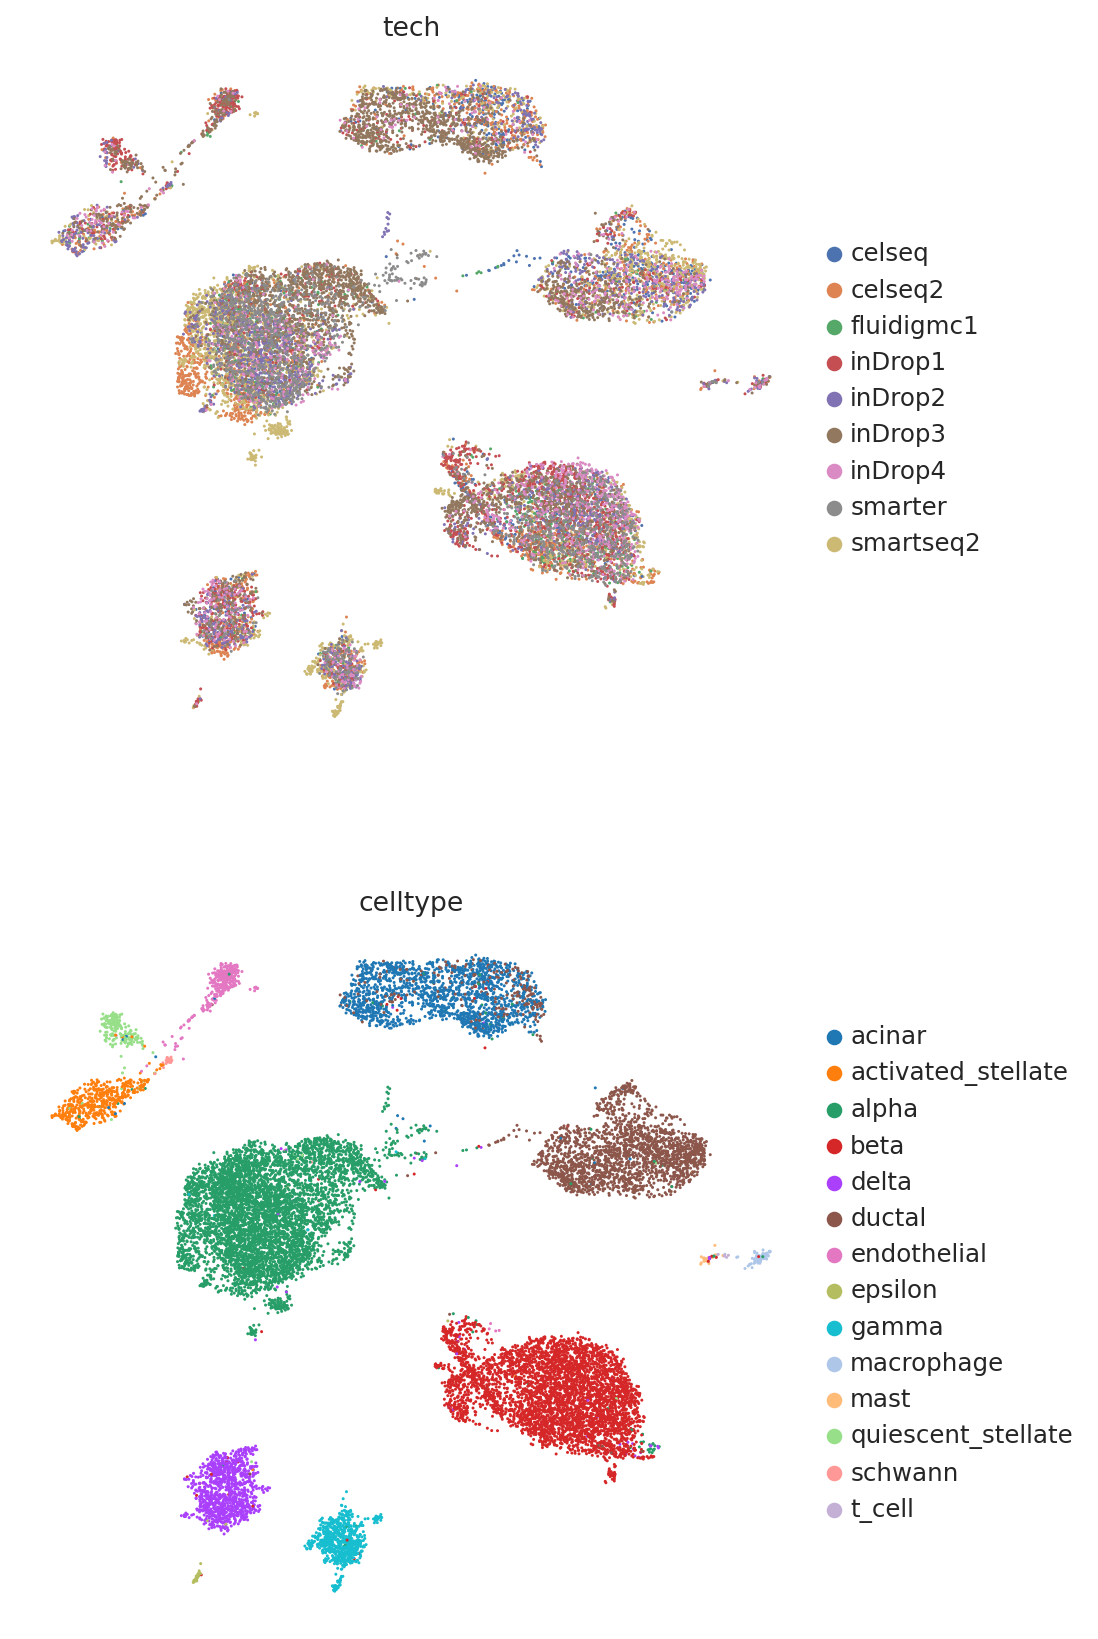

In [ ]:
sc.pl.umap(adata, color=["tech", "celltype"], frameon=False, ncols=1)

In [ ]:
embeddings_dict["X_seurat"] = adata.obsm["X_seurat"]

# Save the embeddings

In [16]:
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("../embeddings/full_annotated_unsupervised_human_pancreas.csv")


# Metric Evaluation

## read the embeddings

In [11]:
# Step 1: Read the CSV file into a DataFrame
import pandas as pd

combined_embeddings = pd.read_csv("../embeddings/full_annotated_unsupervised_human_pancreas.csv", index_col=0)

# Step 2: Ensure indices match
combined_embeddings = combined_embeddings.loc[adata.obs_names]

# Step 3: Split the DataFrame into separate DataFrames for each embedding
embedding_keys = ["X_scVI", "X_harmony", "X_scCRAFT", "X_seurat"]
embeddings_dict = {key: combined_embeddings.filter(like=key) for key in embedding_keys}

# Step 4: Assign the embeddings back to adata.obsm
for key, df in embeddings_dict.items():
    adata.obsm[key] = df.values

# Now `adata.obsm` contains the loaded embeddings

In [10]:
sc.pp.neighbors(adata, use_rep="X_scVI")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="celltype")
df1_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, ilisi_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, clisi_=True, isolated_labels_asw_=True,  batch_key='tech', label_key = 'celltype', embed = 'X_scVI')

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

resolution: 0.1, nmi: 0.8977219019527394
resolution: 0.2, nmi: 0.9030037525843068
resolution: 0.3, nmi: 0.9026749749246965
resolution: 0.4, nmi: 0.9019922301934218
resolution: 0.5, nmi: 0.90296641976149
resolution: 0.6, nmi: 0.9008950350005887
resolution: 0.7, nmi: 0.8937460163316505
resolution: 0.8, nmi: 0.8825135509469767
resolution: 0.9, nmi: 0.8487187045436759
resolution: 1.0, nmi: 0.8347583884304253
resolution: 1.1, nmi: 0.8194217316323456
resolution: 1.2, nmi: 0.7512882904149286
resolution: 1.3, nmi: 0.758150606525034
resolution: 1.4, nmi: 0.7481688528837028
resolution: 1.5, nmi: 0.7225596548957809
resolution: 1.6, nmi: 0.7189942223418101
resolution: 1.7, nmi: 0.7140843969534956
resolution: 1.8, nmi: 0.7086432186294301
resolution: 1.9, nmi: 0.6941063624592916
resolution: 2.0, nmi: 0.6881337645726646
optimised clustering against celltype
optimal cluster resolution: 0.2
optimal score: 0.9030037525843068


/usr/local/lib/python3.10/dist-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


Isolated labels F1...
Compute neighbors on rep X_scVI
Isolated labels ASW...
Graph connectivity...
cLISI score...


/usr/local/lib/python3.10/dist-packages/scib/metrics/lisi.py:175: UserWarning: 'batch_key' is deprecated and will be ignore
  warnings.warn("'batch_key' is deprecated and will be ignore", stacklevel=1)


iLISI score...


In [11]:
sc.pp.neighbors(adata, use_rep="X_harmony")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="celltype")
df2_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, ilisi_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, clisi_=True, isolated_labels_asw_=True,  batch_key='tech', label_key = 'celltype', embed = 'X_harmony')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


resolution: 0.1, nmi: 0.9207331404947834
resolution: 0.2, nmi: 0.9205874229119719
resolution: 0.3, nmi: 0.9209381004190961
resolution: 0.4, nmi: 0.9190036762041395
resolution: 0.5, nmi: 0.911479403949603
resolution: 0.6, nmi: 0.8939687571681566
resolution: 0.7, nmi: 0.8747267570161416
resolution: 0.8, nmi: 0.847135252336408
resolution: 0.9, nmi: 0.8305445601229882
resolution: 1.0, nmi: 0.8011226185202072
resolution: 1.1, nmi: 0.8011365478253036
resolution: 1.2, nmi: 0.7960404012967578
resolution: 1.3, nmi: 0.7765542098163092
resolution: 1.4, nmi: 0.7759166366131206
resolution: 1.5, nmi: 0.7504309870298371
resolution: 1.6, nmi: 0.7654910970209758
resolution: 1.7, nmi: 0.7478512133828872
resolution: 1.8, nmi: 0.7482046587315836
resolution: 1.9, nmi: 0.7428993706096303
resolution: 2.0, nmi: 0.7104326528213233
optimised clustering against celltype
optimal cluster resolution: 0.3
optimal score: 0.9209381004190961


/usr/local/lib/python3.10/dist-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on rep X_harmony
Isolated labels ASW...
Graph connectivity...
cLISI score...


/usr/local/lib/python3.10/dist-packages/scib/metrics/lisi.py:175: UserWarning: 'batch_key' is deprecated and will be ignore
  warnings.warn("'batch_key' is deprecated and will be ignore", stacklevel=1)


iLISI score...


In [12]:
sc.pp.neighbors(adata, use_rep="X_scCRAFT")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="celltype")
df3_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, ilisi_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, clisi_=True, isolated_labels_asw_=True,  batch_key='tech', label_key = 'celltype', embed = 'X_scCRAFT')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


resolution: 0.1, nmi: 0.9173027281952684
resolution: 0.2, nmi: 0.9173027281952684
resolution: 0.3, nmi: 0.9178704582782963
resolution: 0.4, nmi: 0.9179584575152487
resolution: 0.5, nmi: 0.9175907019651851
resolution: 0.6, nmi: 0.9181583907096074
resolution: 0.7, nmi: 0.9185851585874847
resolution: 0.8, nmi: 0.913090533321709
resolution: 0.9, nmi: 0.9129256167638617
resolution: 1.0, nmi: 0.9118621536576127
resolution: 1.1, nmi: 0.8302543694747018
resolution: 1.2, nmi: 0.8298940264286166
resolution: 1.3, nmi: 0.8272144977512905
resolution: 1.4, nmi: 0.8235380764579262
resolution: 1.5, nmi: 0.8112952614342052
resolution: 1.6, nmi: 0.7879691750169583
resolution: 1.7, nmi: 0.7704369155947822
resolution: 1.8, nmi: 0.7743621260921443
resolution: 1.9, nmi: 0.7735819164794611
resolution: 2.0, nmi: 0.7666203649525776
optimised clustering against celltype
optimal cluster resolution: 0.7
optimal score: 0.9185851585874847


/usr/local/lib/python3.10/dist-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on rep X_scCRAFT
Isolated labels ASW...
Graph connectivity...
cLISI score...


/usr/local/lib/python3.10/dist-packages/scib/metrics/lisi.py:175: UserWarning: 'batch_key' is deprecated and will be ignore
  warnings.warn("'batch_key' is deprecated and will be ignore", stacklevel=1)


iLISI score...


In [13]:
sc.pp.neighbors(adata, use_rep="X_seurat")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="celltype")
df4_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, ilisi_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, clisi_=True, isolated_labels_asw_=True,  batch_key='tech', label_key = 'celltype', embed = 'X_seurat')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


resolution: 0.1, nmi: 0.9150864622823117
resolution: 0.2, nmi: 0.9135827161554869
resolution: 0.3, nmi: 0.9095673200646066
resolution: 0.4, nmi: 0.8581640476972106
resolution: 0.5, nmi: 0.8399541880469624
resolution: 0.6, nmi: 0.8346755085108896
resolution: 0.7, nmi: 0.8016551560030764
resolution: 0.8, nmi: 0.7756717163929017
resolution: 0.9, nmi: 0.7731052988071645
resolution: 1.0, nmi: 0.7326273879571387
resolution: 1.1, nmi: 0.7237480021170533
resolution: 1.2, nmi: 0.7096568705474646
resolution: 1.3, nmi: 0.7072704681120915
resolution: 1.4, nmi: 0.7092697439988951
resolution: 1.5, nmi: 0.7064774247685289
resolution: 1.6, nmi: 0.6943147782964555
resolution: 1.7, nmi: 0.6885368326703701
resolution: 1.8, nmi: 0.679321856231247
resolution: 1.9, nmi: 0.6775030330308439
resolution: 2.0, nmi: 0.681938687804775
optimised clustering against celltype
optimal cluster resolution: 0.1
optimal score: 0.9150864622823117


/usr/local/lib/python3.10/dist-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on rep X_seurat
Isolated labels ASW...
Graph connectivity...
cLISI score...


/usr/local/lib/python3.10/dist-packages/scib/metrics/lisi.py:175: UserWarning: 'batch_key' is deprecated and will be ignore
  warnings.warn("'batch_key' is deprecated and will be ignore", stacklevel=1)


iLISI score...


In [14]:
# Adding new columns to each dataframe
df1_1['scVI'] = df1_1.iloc[:, 0]
df2_1['Harmony'] = df2_1.iloc[:, 0]
df3_1['scCRAFT'] = df3_1.iloc[:, 0]
df4_1['Seurat'] = df4_1.iloc[:, 0]

# Selecting only the new columns to avoid duplicate data
df1 = df1_1[['scVI']]
df2 = df2_1[['Harmony']]
df3 = df3_1[['scCRAFT']]
df4 = df4_1[['Seurat']]

# Merging the dataframes along the columns
merged_df_batch = pd.concat([df1, df2, df3, df4], axis=1)

merged_df_batch

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

,scVI,Harmony,scCRAFT,Seurat
NMI_cluster/label,0.907139,0.919287,0.918114,0.912455
ARI_cluster/label,0.945282,0.953225,0.951110,0.947821
ASW_label,0.556335,0.624457,0.696782,0.685445
ASW_label/batch,0.878569,0.871617,0.927987,0.851785
PCR_batch,NaN,NaN,NaN,NaN
cell_cycle_conservation,NaN,NaN,NaN,NaN
isolated_label_F1,0.130841,0.096552,0.097902,0.215385
isolated_label_silhouette,0.714344,0.620789,0.546051,0.630494
graph_conn,0.987088,0.974322,0.959422,0.981263
kBET,NaN,NaN,NaN,NaN


## Batch Effect Removal

### continue with the calculation

In [ ]:
df1_2 = scib.me.metrics(adata, adata, silhouette_=True, ilisi_=True, graph_conn_=True,  batch_key='tech', label_key = 'celltype', embed = 'X_scVI')

Silhouette score...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

Graph connectivity...


/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.1

iLISI score...


In [ ]:
df2_2 = scib.me.metrics(adata, adata, silhouette_=True, ilisi_=True, graph_conn_=True,  batch_key='tech', label_key = 'celltype', embed = 'X_harmony')

Silhouette score...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

Graph connectivity...


/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.1

iLISI score...


In [ ]:
df3_2 = scib.me.metrics(adata, adata, silhouette_=True, ilisi_=True, graph_conn_=True,  batch_key='tech', label_key = 'celltype', embed = 'X_scCRAFT')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Silhouette score...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

Graph connectivity...


/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.1

iLISI score...


In [ ]:
df4_2 = scib.me.metrics(adata, adata, silhouette_=True, ilisi_=True, graph_conn_=True,  batch_key='tech', label_key = 'celltype', embed = 'X_seurat')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Silhouette score...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

Graph connectivity...


/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.1

iLISI score...


In [ ]:
# Adding new columns to each dataframe
df1_2['scANVI'] = df1_2.iloc[:, 0]
df2_2['scGEN'] = df2_2.iloc[:, 0]
df3_2['STACAS'] = df3_2.iloc[:, 0]
df4_2['Seurat'] = df4_2.iloc[:, 0]

# Selecting only the new columns to avoid duplicate data
df1_2 = df1_2[['scANVI']]
df2_2 = df2_2[['scGEN']]
df3_2 = df3_2[['STACAS']]
df4_2 = df4_2[['Seurat']]

# Merging the dataframes along the columns
merged_df_cell = pd.concat([df1_2, df2_2, df3_2, df4_2], axis=1)

merged_df_cell

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,scANVI,scGEN,STACAS,Seurat
NMI_cluster/label,NaN,NaN,NaN,NaN
ARI_cluster/label,NaN,NaN,NaN,NaN
ASW_label,0.556335,0.624457,0.696782,0.685445
ASW_label/batch,0.878569,0.871617,0.927987,0.851785
PCR_batch,NaN,NaN,NaN,NaN
cell_cycle_conservation,NaN,NaN,NaN,NaN
isolated_label_F1,NaN,NaN,NaN,NaN
isolated_label_silhouette,NaN,NaN,NaN,NaN
graph_conn,0.974322,0.974322,0.974322,0.974322
kBET,NaN,NaN,NaN,NaN
